In [106]:
# Imports
import numpy as np
import random
from tqdm.notebook import tqdm
import sys
from common import DATA
import scipy.stats as stats
import matplotlib.pyplot as plt
from time import time
import Baselines
from scipy.special import softmax
from utils import *
import math
from RandomWalkMC import random_walk_mc
from JaccardRandomWalkMC import jacc_random_walk_mc
from Baselines import *
import json
from item_diffs import item_diff_similarity, weighted_item_diff_similarity

In [2]:
adversarial_graph = create_false_node_adversary_graph("epinions_adversarial", DATA['epinions'], n_accounts=150)

In [40]:
# Combining item jaccard and item difference
def item_similarity_recommender(alpha=0.1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += alpha*(data['item_jaccard'][node][o_v]) + (1-alpha)*(data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def intra_item_WA_pearson(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph'][node]:
            if o_v == node:
                continue
            for o_item, rating in data['ratings'][o_v].items():
                similarity_vals[round(rating) - 1] += data['item_sims'][item][o_item]
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def intra_item_WA_jacc(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph'][node]:
            if o_v == node:
                continue
            for o_item, rating in data['ratings'][o_v].items():
                similarity_vals[round(rating) - 1] += data['jaccard_item_sims'][item][o_item]
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations


def item_jaccard_recommender(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += (data['item_jaccard'][node][o_v])
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_jaccard_recommender_WA(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += (data['item_jaccard'][node][o_v])
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_rating_diff_recommender(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += data['item_jaccard'][node][o_v]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations


def item_rating_diff_recommender_new(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                s = 0
                intr = (set(data['ratings'][o_v].keys()).intersection(set(data['ratings'][node].keys()) - {item}))
                for i in intr:
                    s += 1 - (abs(data['ratings'][o_v][i] - data['ratings'][node][i])/4)
                    
                s /= max(len(intr), 1)
                similarity_vals[recommendations[o_v] - 1] += s
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def weighted_item_diffs_new(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                s = 0
                intr = (set(data['ratings'][o_v].keys()).intersection(set(data['ratings'][node].keys()) - {item}))
                for i in intr:
                    s += (1-(abs(data['ratings'][o_v][i] - data['ratings'][node][i])/4)) * data['item_sims'][item][i]
                    
                s /= max(len(intr), 1)
                similarity_vals[round(recommendations[o_v] - 1)] += s
        
        recommendations[node] = round(np.average([x[1] for x in sorted_vals[:5]], weights=[x[0] for x in sorted_vals[:5]]))
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_weighted_majorities(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += (data['jaccard_idx'][node][o_v])
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations


def jaccard_majority_of_majorities(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += (data['jaccard_idx'][node][o_v])
        recommendations[node] = np.argmax(similarity_vals) + 1
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations

def jaccard_weighted_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph'][node]:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += (data['jaccard_idx'][node][o_v])
        recommendations[node] = np.argmax(similarity_vals) + 1
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations

def mode_of_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in data['trust_graph'][node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = stats.mode(ratings)[0][0]

    return recommendations

def mean_of_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in data['trust_graph'][node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = np.mean(ratings)

    return recommendations

def median_of_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in data['trust_graph'][node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = np.median(ratings)

    return recommendations

def jaccard_intra_item_jii(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            for o_item, rating in data['ratings'][o_v].items():
                similarity_vals[round(rating) - 1] += data['jaccard_idx'][node][o_v]*(data['jaccard_item_sims'][item][o_item])
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_jaccard(alpha=0.1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[round(recommendations[o_v]) - 1] += alpha*(data['jaccard_idx'][node][o_v]) + (1-alpha)*(data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def jaccard_item_jaccard_JII(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                sim_rating = 0.5*(data['jaccard_idx'][node][o_v]) + 0.5*(data['item_jaccard'][node][o_v])
                for o_item, rating in data['ratings'][o_v].items():
                    similarity_vals[round(rating) - 1] += sim_rating*(data['jaccard_item_sims'][item][o_item]) / len(data['ratings'][o_v])
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_jaccard_max(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += max(data['jaccard_idx'][node][o_v], data['item_jaccard'][node][o_v])
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_jaccard_mult(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += data['jaccard_idx'][node][o_v]*data['item_jaccard'][node][o_v]
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_jaccard_power_scaling(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += (0.5*math.sqrt(data['jaccard_idx'][node][o_v])) +  0.5*data['item_jaccard'][node][o_v]
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_rating_item_sim_add(alpha=0.1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[round(recommendations[o_v]) - 1] += alpha*(item_diff_similarity(node, o_v, data, item)) + (1-alpha)*(data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def jaccard_item_rating_power_scaling(alpha=1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += max(data['jaccard_idx'][node][o_v]**(1/alpha), data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

# def JWIR_recommender(data, item, test_points):
#     rb = set(data['rated_by'][item])
#     recommendations = {n : data['ratings'][n][item] for n in rb}
    
#     for node in test_points: # loop through nodes which need recommendation
#         similarity_vals = [0 for _ in range(5)]
#         for o_v in data['trust_graph']:
#             if o_v == node:
#                 continue
#             if o_v in recommendations:
#                 WID = weighted_item_diff_similarity(node, o_v, data, item)
#                 if str(item) in WID:
#                     similarity_vals[recommendations[o_v] - 1] += max(data['jaccard_idx'][node][o_v], weighted_item_diff_similarity(node, o_v, data, item)[str(item)])
        
#         recommendations[node] = np.argmax(similarity_vals) + 1

#         if np.max(similarity_vals) == 0:
#             recommendations[node] = random.choice([1,2,3,4,5])
            
#     return recommendations

def weighted_item_diffs(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v] - 1)] += weighted_item_diff_similarity(node, o_v, data, data['item_sims'], item)
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jii_weighted_item_diffs(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v] - 1)] += weighted_item_diff_similarity(node, o_v, data, data['jaccard_item_sims'], item)
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_weighted_item_diffs(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += data['jaccard_idx'][node][o_v] + weighted_item_diff_similarity(node, o_v, data, data['jaccard_item_sims'], item)
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_diff_recommender(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[round(recommendations[o_v]) - 1] += item_diff_similarity(node, o_v, data, item)
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_diff_recommender_WA(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[min(max(round(recommendations[o_v] - 1), 0), 4)] += item_diff_similarity(node, o_v, data, item)
        
        recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

# Define our algorithms

In [108]:
algorithms = {
    'Random': random_recommender,
    'Universal Random': universal_recommender,
    'Mode of Neighbours': mode_of_neighbours,
    'Mean of Neighbours': mean_of_neighbours,
    'Median of Neighbours': median_of_neighbours,
    'Jaccard Weighted Neighbours': jaccard_weighted_neighbours,
    'Jaccard Monte-Carlo Random Walk': jacc_random_walk_mc,
    'Monte-Carlo Random Walk': random_walk_mc,
    'Jaccard MoM': jaccard_majority_of_majorities,
    'Jaccard WA': jaccard_weighted_majorities,
    'Item-Jaccard WA': item_jaccard_recommender_WA,
    'Item-Rating Difference WA': item_diff_recommender,
    'Intra-Item WA': intra_item_WA_jacc,
    'Jaccard Intra-Item WA': jaccard_intra_item_jii,
    'WIRD WA': jii_weighted_item_diffs,
    'JWIRD WA': jaccard_weighted_item_diffs,
    'Jaccard Item-Jaccard WA': jaccard_item_jaccard(alpha=0.5),
    'Jaccard Item-Jaccard JII Combination WA': jaccard_item_jaccard_JII,
    'Intra-Item WA (Pearson)': intra_item_WA_pearson,
}

In [10]:
with open('./results.json', 'r') as infile:
    results = json.load(infile)

In [109]:
results = {}

In [110]:
for k, recommender in algorithms.items():
    if k in results:
        continue
    sample_sizes, accs, mses, mes, timing = [], [], [], [], []
    # for d in DATA.values():
    d = DATA['filmtrust']
    for i in tqdm(d['items'][:5]): # Top 5 items
        for _ in range(5): # run 5 times for each item
            before_time = time()
            acc, mse, me = evaluate(recommender, d, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me), timing.append(time() - before_time)

    results[k] = {
        'sample_sizes': sample_sizes,
        'acc': accs,
        'mse': mses,
        'me': mes,
        'timing': timing,
    }

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:234: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  recommendations[node] = stats.mode(ratings)[0][0]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:180: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:522: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:54: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:284: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:484: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:503: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:35: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


In [107]:
# with open('results.json', 'w+') as outfile:
#     json.dump(results, outfile)

In [89]:
results.keys()

dict_keys(['Random', 'Universal Random', 'Mode of Neighbours', 'Mean of Neighbours', 'Median of Neighbours', 'Jaccard Weighted Neighbours', 'Monte-Carlo Random Walk', 'Jaccard WA', 'Item-Jaccard WA', 'Item-Rating Difference WA', 'Intra-Item WA', 'Jaccard Item-Jaccard WA', 'Jaccard Item-Jaccard JII Combination WA', 'Jaccard Monte-Carlo Random Walk', 'Jaccard MoM', 'Intra-Item WA (Pearson)', 'Jaccard Intra-Item WA', 'JWIRD WA', 'WIRD WA'])

Jaccard Item-Jaccard WA & \textbf{0.66} & 0.08 \\
JWIRD WA & 0.67 & 0.07 \\
Item-Rating Difference WA & 0.67 & 0.08 \\
Item-Jaccard WA & 0.67 & 0.08 \\
WIRD WA & 0.67 & \textbf{0.04} \\
Jaccard Item-Jaccard JII Combination WA & 0.69 & 0.06 \\
Universal Random & 0.89 & 0.11 \\
Jaccard Intra-Item WA & 1.07 & 0.06 \\
Jaccard WA & 1.14 & 0.08 \\
Jaccard MoM & 1.19 & 0.09 \\
Jaccard Monte-Carlo Random Walk & 1.20 & 0.08 \\
Monte-Carlo Random Walk & 1.20 & 0.08 \\
Intra-Item WA & 1.21 & 0.07 \\
Jaccard Weighted Neighbours & 1.22 & 0.10 \\
Mode of Neighbours & 1.23 & 0.09 \\
Mean of Neighbours & 1.25 & 0.07 \\
Median of Neighbours & 1.26 & 0.08 \\
Intra-Item WA (Pearson) & 1.27 & 0.14 \\
Random & 1.34 & 0.07 \\


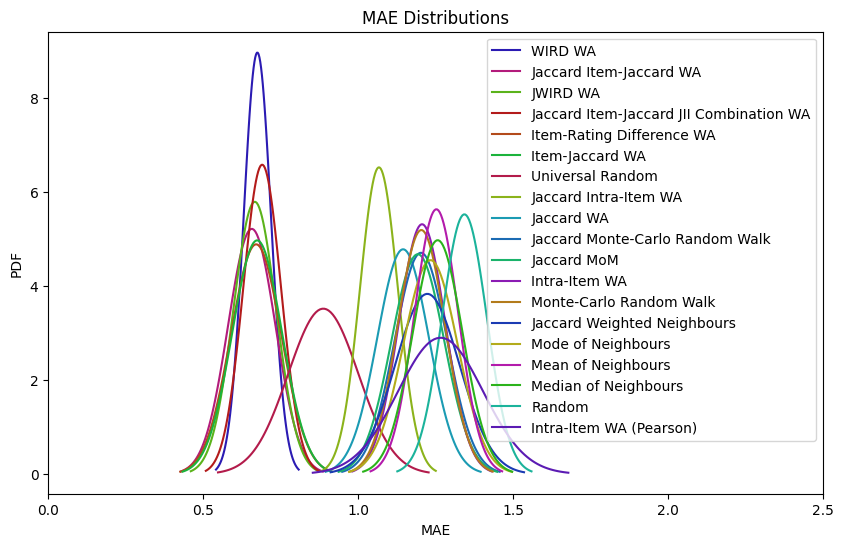

In [111]:
import colorsys
N = len(results)
HSV_tuples = [(x*1.0/N, 0.85, 0.7) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
random.shuffle(RGB_tuples)

fig = plt.figure(figsize=(10, 6))

keep_algs = list(results.keys())
# keep_algs = [
#     'Random',
#     'Universal Random',
#     'Item-Jaccard WA',
#     'Jaccard Item-Jaccard WA',
#     'Jaccard Item-Jaccard JII Combination WA',
# ]

result_items = sorted(list([(a, v) for a, v in results.items(
) if a in keep_algs]), key=lambda x: np.mean(x[1]['mse']))

plt.xlim(0, 2.5)
plt.title("MAE Distributions")
names, mae, std = [], [], []
for i, (name, res) in enumerate(result_items):
    mu = np.mean(res['me'])
    sigma = np.std(res['me'])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=name, color=RGB_tuples[i])
    names.append(name)
    mae.append(mu)
    std.append(sigma)

nms = list(zip(names, mae, std))
nms.sort(key=lambda x: (x[1], x[2]))

for name, m, s in nms:
    min_mae = round(m, 2) == round(min(mae), 2)
    min_s = round(s, 2) == round(min(std), 2)
    text_bf = '\\textbf{'
    print(f"{name} & {text_bf if min_mae else ''}{m:.2f}{'}' if min_mae else ''} & {text_bf if min_s else ''}{s:.2f}{'}' if min_s else ''} \\\\")
plt.legend( loc='upper right')
plt.ylabel("PDF")
plt.xlabel("MAE")
plt.show()


# Adversarial Testing

In [100]:
adversarial_results = {}

In [101]:
# Select algorithms we want to test
adversarial_algorithms = [
    'Jaccard WA',
    'Jaccard Monte-Carlo Random Walk',
    'Item-Jaccard WA',
    'WIRD WA',
    'Jaccard Item-Jaccard WA',
    'Jaccard Item-Jaccard JII Combination WA',
]

# Compute adversarial results
for k in adversarial_algorithms:
    recommender = algorithms[k]
    if k in adversarial_results:
        continue
    sample_sizes, accs, mses, mes, timing = [], [], [], [], []
    # for d in DATA.values():
    d = DATA['epinions_adversial']
    for i in tqdm(d['items'][:5]): 
        for _ in range(5): # run 5 times for each item
            before_time = time()
            acc, mse, me = evaluate(recommender, d, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me), timing.append(time() - before_time)

    adversarial_results[k] = {
        'sample_sizes': sample_sizes,
        'acc': accs,
        'mse': mses,
        'me': mes,
        'timing': timing,
    }

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:180: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_85540/309901430.py:484: RuntimeWarning: invalid value encountered in divide
  recommendations[node] = np.sum(np.array([i + 1 for i in range(5)]) * np.array(similarity_vals)/np.sum(similarity_vals))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

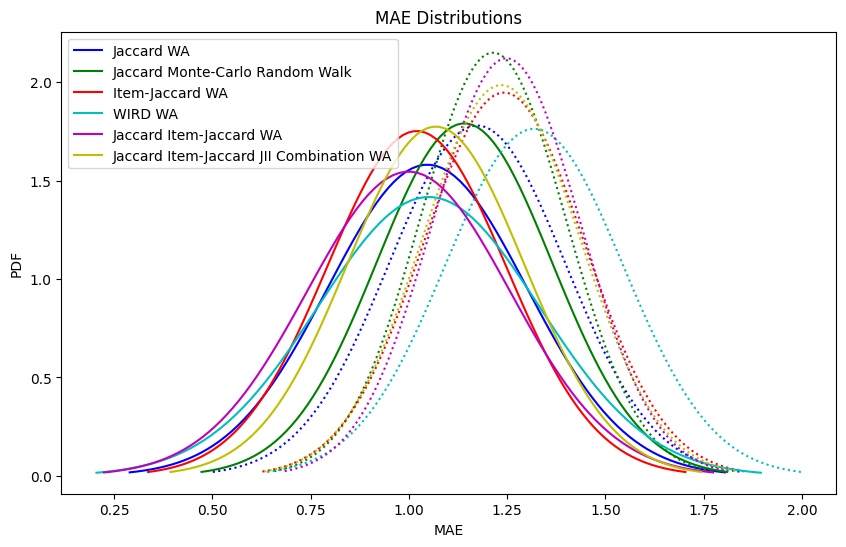

In [104]:
# Extract mean and standard deviation for each algorithm in normal and adversarial scenarios
normal_data = {alg: [np.mean(res['me']), np.std(res['me'])] for alg, res in results.items()}
adversarial_data = {alg: [np.mean(res['me']), np.std(res['me'])] for alg, res in adversarial_results.items()}

# Generate some colors
colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, ax = plt.figure(figsize=(10, 6)), plt.gca()

for i, alg in enumerate(adversarial_results.keys()):
    # Extracting mu and sigma for both normal and adversarial data
    mu, sigma = normal_data[alg]
    mu_adv, sigma_adv = adversarial_data.get(alg, (None, None)) # Using get to avoid KeyError
    
    # Creating a range for x-axis based on the mu and sigma
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    
    # Plotting the normal data
    ax.plot(x, stats.norm.pdf(x, mu, sigma), label=alg, color=colors[i])
    
    # Check if there is adversarial data for the algorithm
    if mu_adv is not None and sigma_adv is not None:
        # Creating a range for x-axis based on the mu_adv and sigma_adv
        x_adv = np.linspace(mu_adv - 3*sigma_adv, mu_adv + 3*sigma_adv, 100)
        # Plotting the adversarial data with dotted lines
        ax.plot(x_adv, stats.norm.pdf(x_adv, mu_adv, sigma_adv), linestyle='dotted', color=colors[i])

# Adding legend and labels
ax.legend()
plt.ylabel("PDF")
plt.xlabel("MAE")
plt.title("MAE Distributions")

# Adding custom legend/label for solid and dotted lines
handles, labels = ax.get_legend_handles_labels()
solid_line = plt.Line2D([0], [0], color='black', linewidth=1.5, linestyle='-')
dotted_line = plt.Line2D([0], [0], color='black', linewidth=1.5, linestyle=':')
plt.legend([solid_line, dotted_line], ['Normal', 'Adversarial'], loc='upper right')

# Returning original legend
ax.legend(handles, labels, loc='upper left')

plt.show()

In [105]:

for i, alg in enumerate(adversarial_results.keys()):
    # Extracting mu and sigma for both normal and adversarial data
    mu, sigma = normal_data[alg]
    mu_adv, sigma_adv = adversarial_data.get(alg, (None, None)) # Using get to avoid KeyError
    print(f"{alg} & {mu:.2f} & {sigma:.2f} & {mu_adv:.2f} & {sigma_adv:.2f} & {((mu_adv - mu)/mu)*100 : .2f} \\\\")

Jaccard WA & 1.05 & 0.25 & 1.17 & 0.22 &  12.12 \\
Jaccard Monte-Carlo Random Walk & 1.14 & 0.22 & 1.21 & 0.19 &  6.39 \\
Item-Jaccard WA & 1.02 & 0.23 & 1.24 & 0.20 &  21.77 \\
WIRD WA & 1.05 & 0.28 & 1.32 & 0.23 &  25.53 \\
Jaccard Item-Jaccard WA & 1.00 & 0.26 & 1.25 & 0.19 &  24.93 \\
Jaccard Item-Jaccard JII Combination WA & 1.07 & 0.22 & 1.23 & 0.20 &  15.58 \\


In [120]:
with open('../datasets/CiaoDVD/movie-ratings.txt', 'r') as infile:
    lines = infile.readlines()
    split_lines = map(lambda x: x.strip().split(','), lines)
    finals = list(map(lambda x: (x[0], x[1], x[4]), split_lines))
    with open('../datasets/CiaoDVD/ratings_data.txt', 'w+') as outfile:
        outfile.write('\n'.join([','.join(x) for x in finals]))
        